# Uncertainty Results
In this Notebook we show the results on the freesolv dataset for VI, Langevin, Ensembling.
The Langevin and Ensembling results are loaded from samples collected in other notebooks (see training notebooks). 
The Variational results are sampled here, so the sampling based results will vary (increase number of samples to reduce this variation).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
from os import path
import copy

from chemprop.features import BatchMolGraph, MolGraph
from chemprop.data.data import MoleculeDatapoint, MoleculeDataset
from chemprop.data import MoleculeDataLoader, split_data
import torch
td = torch.distributions
from chemprop.args import TrainArgs, HyperoptArgs
from tqdm import tqdm
from chemprop.models.model import BayesianMoleculeModel
from chemprop.features.featurization import BatchMolGraph
from chemprop.data import get_data

In [2]:
def plot_coverage(y_pred_s, title):
    pred_ints = np.linspace(0, 1, 100)[1:]
    y_test = np.array(target_batch)
    icp = []
    for pred_int in pred_ints:
        p_upper = 1 - (1-pred_int)/2
        p_lower = p_upper - pred_int
        q1 = np.quantile(y_pred_s, p_lower, axis=0)
        q2 = np.quantile(y_pred_s, p_upper, axis=0)

        icp.append(np.mean(np.logical_and(y_test.squeeze() < q2, y_test.squeeze() > q1)))
    
    x_perf = np.linspace(0, 1, 1000)
    plt.plot(x_perf, x_perf)
    plt.plot(icp, pred_ints)
    plt.xlabel('Estimated Interval Coverage')
    plt.ylabel('Prediction Interval')
    plt.axis('equal')
    plt.title(title)
    plt.show()

In [3]:
def error_calibration(y_pred, y_std, title):
    sort_index = np.argsort(y_std)
    y_test_ = y_test[sort_index]
    y_pred_ = y_pred[sort_index]
    y_std_ = y_std[sort_index]
    aggregate_every = 6
    rmse = np.empty((len(test_data) // aggregate_every))
    sigma = np.empty((len(test_data) // aggregate_every))

    for i in range(len(test_data) // aggregate_every):
        y_test_agr = y_test_[i*aggregate_every:(i+1)*aggregate_every, targ_index]
        y_pred_agr = y_pred_[i*aggregate_every:(i+1)*aggregate_every]
        y_std_agr  = y_std_[i*aggregate_every:(i+1)*aggregate_every]

        sigma[i] = np.mean(y_std_agr)
        rmse[i] = np.sqrt(np.mean((y_pred_agr - y_test_agr)**2))
    ence = ENCE(sigma, rmse)
    return sigma, rmse, ence

In [4]:
def ENCE(sigma, rmse):
    return np.mean(np.abs(sigma - rmse) / sigma)

In [5]:
class BayesianArgs(TrainArgs):
    sigma1 = torch.tensor(1)
    sigma2 = torch.tensor(np.exp(-6.0))
    prior = td.Normal(0,1)
    data_path = "data/freesolv.csv" #"data/leo_sulphamides.csv"
    init = 'zeros' 
    init_lr = 1e-5
    max_lr = 1e-3
    final_lr = 1e-4
    split_sizes = (0.8, 0.1, 0.1)
    epochs = 5000
    warmup_epochs = 10

args = BayesianArgs()
if args.data_path == "data/leo_sulphamides.csv":
    args.num_tasks = 5
else:
    args.num_tasks = 1
args.ffn_hidden_size = 100
args.hidden_size = 100
args.ffn_num_layers = 3
args.depth = 6
args.dropout = 0.0 # Changed from 0.15
args.num_workers = 0
args.batch_size = 50 #200 # Changed from 50
args.dataset_type = 'regression'

/work3/s164180/anaconda3/envs/chemprop/lib/python3.8/site-packages/tap/tap.py:304: UserWarning: add_arguments is deprecated and will be removed on January 1st, 2021 please override "configure" instead and call add_argument there. 
  warn('add_arguments is deprecated and will be removed on January 1st, 2021'


In [27]:
load_trained = True
device = torch.device('cuda')
mod = BayesianMoleculeModel(args, device=device)

path_name = args.data_path.partition("/")[2].partition(".")[0]
path_name += f"_hidden_{args.ffn_hidden_size}"
path_name += f"_ffn_num_{args.ffn_num_layers}"
path_name += f"_depth_{args.depth}"
path_name += f"_dropout_{args.dropout}"
path_name += f"_epochs_{args.epochs}"

checkpoints = os.listdir("Checkpoints/")
max_epochs = 0
for check in checkpoints:
    if check.partition("epochs_")[0].startswith(path_name.partition("epochs_")[0]):
        if int(check.partition("epochs_")[2].partition(".")[0]) > max_epochs:
            max_epochs = int(check.partition("epochs_")[2].partition(".")[0])
            path_name = check

if load_trained and path.exists(f"Checkpoints/{path_name}"):
    print("Checkpoint found:", f"Checkpoints/{path_name}")
    mod.load_state_dict(torch.load(f"Checkpoints/{path_name}"))

In [6]:
data = get_data(path=args.data_path, args=args, skip_none_targets=True)
train_data, val_data, test_data = split_data(data=data, 
                                             split_type=args.split_type, 
                                             sizes=args.split_sizes, 
                                             seed=args.seed, 
                                             num_folds=args.num_folds, 
                                             args=args, 
                                             logger=None)

642it [00:00, 228275.96it/s]
100%|██████████| 642/642 [00:00<00:00, 9395.11it/s]


In [28]:
# Standardise train/val/test sets by training set's mean/std
targets_train_np = np.array(train_data.targets())
targets_val_np = np.array(val_data.targets())
targets_test_np = np.array(test_data.targets())
y_mean_train = np.mean(targets_train_np, axis=0)
y_std_train = np.std(targets_train_np, axis=0)
targets_train_np = (targets_train_np - y_mean_train)/y_std_train
targets_val_np = (targets_val_np - y_mean_train)/y_std_train
targets_test_np = (targets_test_np - y_mean_train)/y_std_train

train_data.set_targets(targets_train_np)
val_data.set_targets(targets_val_np)
test_data.set_targets(targets_test_np)



# Variational Inference

In [11]:
test_data_loader = MoleculeDataLoader(dataset=test_data,batch_size=len(test_data),num_workers=args.num_workers)
batch = next(iter(test_data_loader))
mol_batch, features_batch, target_batch, atom_descriptors_batch = \
            batch.batch_graph(), batch.features(), batch.targets(), batch.atom_descriptors()
y_test = np.array(target_batch)

In [10]:
mod.eval()
mod.to(device)

S = 5000
targ_index = 0
mod.sampling_mode(True)
batch = next(iter(test_data_loader))
mol_batch, features_batch, target_batch, atom_descriptors_batch = \
            batch.batch_graph(), batch.features(), batch.targets(), batch.atom_descriptors()
y_test = np.array(target_batch)
y_mean = np.empty((S, len(test_data)))
y_var = np.empty((S, len(test_data)))
y_pred_s = np.empty((S, len(test_data)))
for s in range(S):
    y_pred_mean, y_pred_rho = mod.forward(mol_batch[0])
    y_pred_std = mod.softplus(y_pred_rho) + mod.eps
    
    y_pred_var = (y_pred_std)**2
    y_var[s] = y_pred_var.cpu().detach().numpy()[:, targ_index]
    y_mean[s] = y_pred_mean.cpu().detach().numpy()[:, targ_index]
    y_pred_s[s] = td.Normal(y_pred_mean, y_pred_std).sample().cpu().detach().numpy()[:,targ_index]

In [11]:
print("RMSE:", np.sqrt(np.mean((np.mean(y_pred_s, axis=0) - y_test.squeeze())**2)))

RMSE: 0.2089339901142428


In [13]:
mod.sampling_mode(False)
y_pred_mean, _ = mod.forward(mol_batch[0])
y_pred_mean = y_pred_mean.cpu().detach().numpy()[:, targ_index]
print("RMSE (non-sampling):", np.sqrt(np.mean((y_pred_mean - y_test.squeeze())**2)))

RMSE (non-sampling): 0.2210691192451952


In [14]:
y_pred = np.mean(y_mean, axis=0)
y_var_al = np.mean(y_var, axis=0)
y_std_al = np.sqrt(y_var_al)

y_var_epi = np.var(y_mean, axis=0)
y_std_epi = np.sqrt(y_var_epi)

y_var_total = y_var_al + y_var_epi
y_std_tot = np.sqrt(y_var_total)

y_std_sample = np.std(y_pred_s, axis=0)

C:\Users\snowy\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


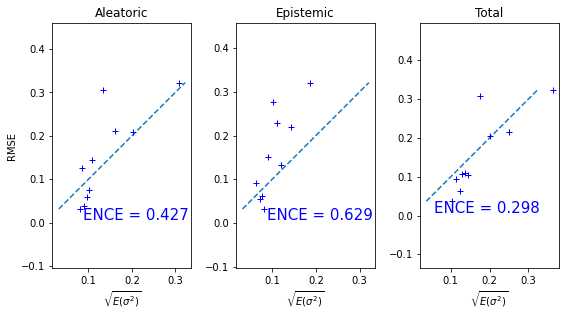

In [15]:
fig, axs = plt.subplots(1, 3, sharey=False, constrained_layout=True, figsize=(8,4))
axs[0].set_ylabel('RMSE')
fig.tight_layout()
y_stds = [y_std_al, y_std_epi, y_std_sample]
titles = ['Aleatoric', 'Epistemic', 'Total']

for i, (title, y_std) in enumerate(zip(titles, y_stds)):
    sigma, rmse, ence = error_calibration(y_pred, y_std, title='Aleatoric')
    x = np.linspace(np.min(rmse),np.max(rmse),100)
    y = x
    
    axs[i].plot(x, y, '--')
    axs[i].plot(sigma, rmse, 'b+')
    axs[i].set_xlabel('$\sqrt{E(\sigma^2)}$')
    axs[i].set_ylim(np.min(rmse), np.max(rmse))
    axs[i].axis('equal')
    axs[i].text(0.33, 0.00, f'ENCE = {round(ence, 3)}',
        verticalalignment='bottom', horizontalalignment='right',
        color='blue', fontsize=15)
    axs[i].set_title(title)

## Langevin (MCMC Sampling)

In [17]:
Langevin_pred= np.loadtxt('langevin_mean.txt')
Langevin_std= np.loadtxt('langevin_std.txt')
Langevin_pred = Langevin_pred
Langevin_std = Langevin_std

y_pred = np.mean(Langevin_pred, axis=0) #
y_var_epi = np.std(Langevin_pred, axis=0)**2 #epistemisk
y_var_ale = np.mean(Langevin_std**2, axis=0) #aleatroisk

y_std_ale = np.sqrt(y_var_ale)
y_std_epi = np.sqrt(y_var_epi)

y_std = np.sqrt(y_var_epi+y_var_ale)

In [18]:
print("RMSE:", np.sqrt(np.mean((y_pred - y_test.squeeze())**2)))

RMSE: 0.3520858931237336


C:\Users\snowy\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


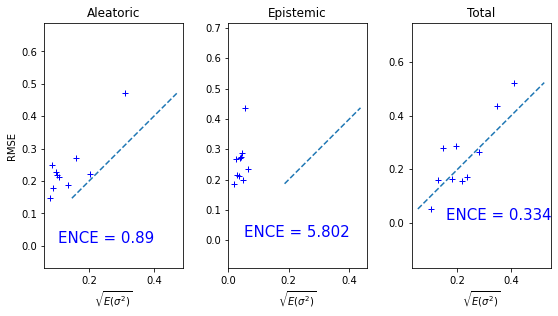

In [19]:
fig, axs = plt.subplots(1, 3, sharey=False, constrained_layout=True, figsize=(8,4))
axs[0].set_ylabel('RMSE')
fig.tight_layout()
y_stds = [y_std_al, y_std_epi, y_std]
titles = ['Aleatoric', 'Epistemic', 'Total']
alignments = [0.4, 0.4, 0.55]

for i, (title, y_std, align) in enumerate(zip(titles, y_stds, alignments)):
    sigma, rmse, ence = error_calibration(y_pred, y_std, title='Aleatoric')
    x = np.linspace(np.min(rmse),np.max(rmse),100)
    y = x
    
    axs[i].plot(x, y, '--')
    axs[i].plot(sigma, rmse, 'b+')
    axs[i].set_xlabel('$\sqrt{E(\sigma^2)}$')
    axs[i].set_ylim(np.min(rmse), np.max(rmse))
    axs[i].axis('equal')
    axs[i].text(align, 0.00, f'ENCE = {round(ence, 3)}',
        verticalalignment='bottom', horizontalalignment='right',
        color='blue', fontsize=15)
    axs[i].set_title(title)

In [20]:
S=len(Langevin_pred)
y_pred_s_lang = np.empty((S, len(test_data)))
for s in range(S):
    y_pred_s_lang[s] = np.random.normal(Langevin_pred[s], Langevin_std[s])

## Ensemble - Hetero

In [65]:
pred= np.loadtxt('y_pred_hetero_freesolv.txt')
std= np.loadtxt('y_std_hetero_freesolv.txt')


In [66]:
ensemble_pred = pred
ensemble_std = std

y_pred = np.mean(ensemble_pred, axis=0) #
y_var_epi = np.std(ensemble_pred, axis=0)**2 #epistemisk
y_var_ale = np.mean(ensemble_std**2, axis=0) #aleatroisk

y_std_ale = np.sqrt(y_var_ale)
y_std_epi = np.sqrt(y_var_epi)

y_std = np.sqrt(y_var_epi+y_var_ale)

In [67]:
print("RMSE:", np.sqrt(np.mean((y_pred - y_test.squeeze())**2)))

RMSE: 0.2659658793609678


<ipython-input-68-8c3b5833800b>:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


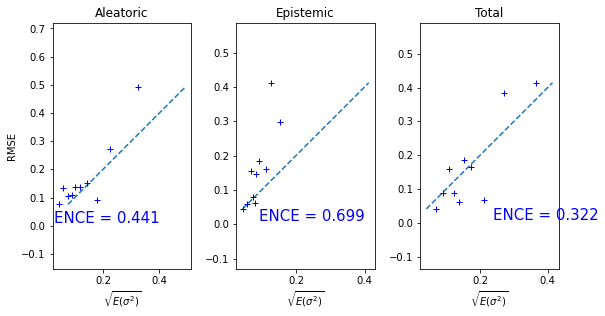

In [68]:
fig, axs = plt.subplots(1, 3, sharey=False, constrained_layout=True, figsize=(8,4))
axs[0].set_ylabel('RMSE')
fig.tight_layout()
y_stds = [y_std_ale, y_std_epi, y_std]
titles = ['Aleatoric', 'Epistemic', 'Total']

targ_index = 0
alignments = [0.4, 0.4, 0.55]

for i, (title, y_std, align) in enumerate(zip(titles, y_stds, alignments)):
    sigma, rmse, ence = error_calibration(y_pred, y_std, title='Aleatoric')
    x = np.linspace(np.min(rmse),np.max(rmse),100)
    y = x
    
    axs[i].plot(x, y, '--')
    axs[i].plot(sigma, rmse, 'b+')
    axs[i].set_xlabel('$\sqrt{E(\sigma^2)}$')
    axs[i].set_ylim(np.min(rmse), np.max(rmse))
    axs[i].axis('equal')
    axs[i].text(align, 0.00, f'ENCE = {round(ence, 3)}',
        verticalalignment='bottom', horizontalalignment='right',
        color='blue', fontsize=15)
    axs[i].set_title(title)

# Coverage Plots

C:\Users\snowy\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


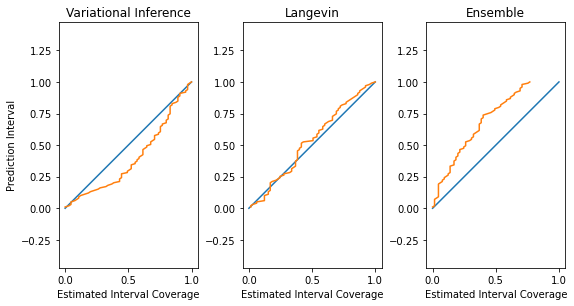

In [25]:
fig, axs = plt.subplots(1, 3, sharey=False, constrained_layout=True, figsize=(8,4))
axs[0].set_ylabel('RMSE')
fig.tight_layout()
y_pred_samples = [y_pred_s, y_pred_s_lang, ensemble_pred]
model_names = ["Variational Inference", "Langevin", "Ensemble"]

axs[0].set_ylabel('Prediction Interval')
for i, (y_pred_sample, model_name) in enumerate(zip(y_pred_samples, model_names)):
    pred_ints = np.linspace(0, 1, 100)[1:]
    y_test = np.array(target_batch)
    icp = []
    for pred_int in pred_ints:
        p_upper = 1 - (1-pred_int)/2
        p_lower = p_upper - pred_int
        q1 = np.quantile(y_pred_sample, p_lower, axis=0)
        q2 = np.quantile(y_pred_sample, p_upper, axis=0)

        icp.append(np.mean(np.logical_and(y_test.squeeze() < q2, y_test.squeeze() > q1)))

    x_perf = np.linspace(0, 1, 1000)
    axs[i].plot(x_perf, x_perf)
    axs[i].plot(icp, pred_ints)
    axs[i].set_xlabel('Estimated Interval Coverage')
    axs[i].axis('equal')
    axs[i].set_title(model_name)